# 🎵 Short-Time Fourier Transform (STFT) Explained

**Reference:** Valerio Velardo - The Sound of AI  
**Video:** "Short-Time Fourier Transform Explained Easily"  
**GitHub:** [AudioSignalProcessingForML](https://github.com/musikalkemist/AudioSignalProcessingForML)

---

## 📚 Table of Contents

1. [Introduction: The Problem with Fourier Transform](#1-introduction)
2. [The Solution: Short-Time Fourier Transform](#2-the-solution)
3. [The STFT Process Step-by-Step](#3-stft-process)
4. [The Output: Spectrogram](#4-spectrogram)
5. [The Time-Frequency Trade-off](#5-time-frequency-tradeoff)
6. [Key Parameters](#6-key-parameters)
7. [Implementation with Librosa](#7-implementation)
8. [Applications in AI/Deep Learning](#8-applications)
9. [Summary and Best Practices](#9-summary)

---

## 🔧 Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy import signal
from scipy.fft import fft, fftfreq
import IPython.display as ipd
import os
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✅ All libraries imported successfully!")
print(f"Librosa version: {librosa.__version__}")
print(f"NumPy version: {np.__version__}")

✅ All libraries imported successfully!
Librosa version: 0.11.0
NumPy version: 2.0.2


---

## 1. 🌊 Introduction: The Problem with Fourier Transform

### What Does the Standard Fourier Transform Do?

The **Fourier Transform (FT)** or **Discrete Fourier Transform (DFT)** converts a time-domain signal into the frequency domain:

- **Input**: Time-domain signal (waveform)
- **Output**: Frequency-domain representation (spectrum)
- **Information**: Which frequencies are present and their magnitudes

### The Critical Problem: Loss of Time Information ⚠️

The standard FT **discards all time information**:

- You know **WHAT** frequencies are in the signal
- You **DON'T** know **WHEN** they occur

### Why This Matters for Real Audio

Real-world audio signals are **non-stationary** - their frequency content changes over time:

- **Music**: Different notes play at different times
- **Speech**: Phonemes have different spectral characteristics
- **Environmental sounds**: Events occur at specific moments

### Example Scenario

Imagine analyzing a piano piece:

- **Standard FT**: "This piece contains frequencies 261 Hz (C), 329 Hz (E), 392 Hz (G)"
- **What we need**: "C plays at 0-1s, E plays at 1-2s, G plays at 2-3s"

Let's demonstrate this problem:

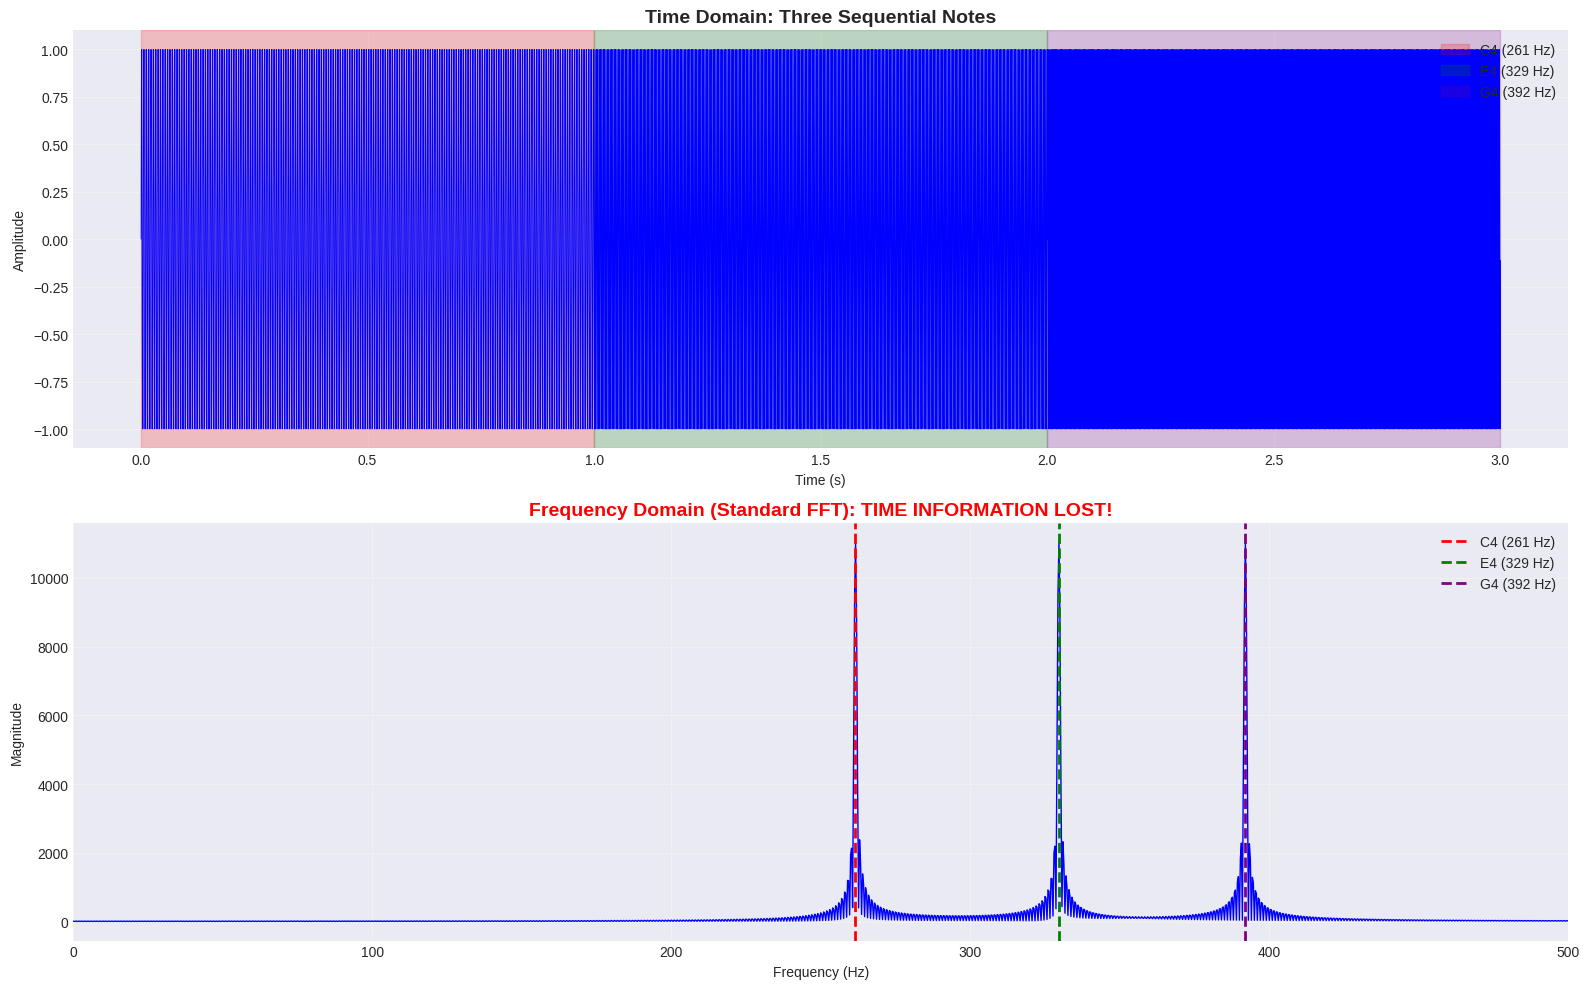

Key Observation:
Top: We can SEE when each note plays (time domain)
Bottom: FFT shows all three frequencies, but NOT when they occurred!
This is the fundamental problem STFT solves.


In [2]:
sr = 22050
duration = 3.0

t1 = np.linspace(0, 1, sr, endpoint=False)
t2 = np.linspace(1, 2, sr, endpoint=False)
t3 = np.linspace(2, 3, sr, endpoint=False)

note_C = np.sin(2 * np.pi * 261.63 * t1)
note_E = np.sin(2 * np.pi * 329.63 * t2)
note_G = np.sin(2 * np.pi * 392.00 * t3)

signal_sequential = np.concatenate([note_C, note_E, note_G])
t_full = np.linspace(0, duration, len(signal_sequential))

fft_result = fft(signal_sequential)
magnitude = np.abs(fft_result)
freqs = fftfreq(len(signal_sequential), 1/sr)

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

axes[0].plot(t_full, signal_sequential, linewidth=0.5, color='blue')
axes[0].axvspan(0, 1, alpha=0.2, color='red', label='C4 (261 Hz)')
axes[0].axvspan(1, 2, alpha=0.2, color='green', label='E4 (329 Hz)')
axes[0].axvspan(2, 3, alpha=0.2, color='purple', label='G4 (392 Hz)')
axes[0].set_title('Time Domain: Three Sequential Notes', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

axes[1].plot(freqs[:len(freqs)//2], magnitude[:len(magnitude)//2], linewidth=1, color='blue')
axes[1].axvline(x=261.63, color='red', linestyle='--', linewidth=2, label='C4 (261 Hz)')
axes[1].axvline(x=329.63, color='green', linestyle='--', linewidth=2, label='E4 (329 Hz)')
axes[1].axvline(x=392.00, color='purple', linestyle='--', linewidth=2, label='G4 (392 Hz)')
axes[1].set_title('Frequency Domain (Standard FFT): TIME INFORMATION LOST!', fontsize=14, fontweight='bold', color='red')
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Magnitude')
axes[1].set_xlim(0, 500)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key Observation:")
print("Top: We can SEE when each note plays (time domain)")
print("Bottom: FFT shows all three frequencies, but NOT when they occurred!")
print("This is the fundamental problem STFT solves.")

### 📊 The Core Issue Summarized

| Aspect | Standard FFT | What We Need |
|--------|-------------|-------------|
| **Input** | Entire signal | Small time segments |
| **Output** | Average frequency content | Frequency content **at each time** |
| **Time Info** | ❌ Lost | ✅ Preserved |
| **Use Case** | Stationary signals | Non-stationary signals (real audio) |
| **Result** | Single spectrum | Time-varying spectrum (spectrogram) |

---

## 2. 💡 The Solution: Short-Time Fourier Transform (STFT)

### Core Idea

Instead of analyzing the **entire signal at once**, we:

1. **Break the signal** into small, overlapping segments (frames)
2. **Apply FFT** to each frame individually
3. **Stack the results** to create a time-frequency representation

### The STFT Equation

The Short-Time Fourier Transform is mathematically defined as:

$$
\text{STFT}\{x[n]\}(m, \omega) = \sum_{n=-\infty}^{\infty} x[n] \cdot w[n-m] \cdot e^{-j\omega n}
$$

Where:
- $x[n]$ = input signal
- $w[n]$ = window function
- $m$ = time frame index
- $\omega$ = frequency
- $e^{-j\omega n}$ = complex exponential (basis function)

### In Simpler Terms

For each time frame $m$:
1. Extract a segment of the signal
2. Apply a window function $w[n]$
3. Compute the FFT
4. Store the result

### Key Advantage

STFT gives us **frequency content localized in time** - we know both:
- **WHAT** frequencies are present
- **WHEN** they occur

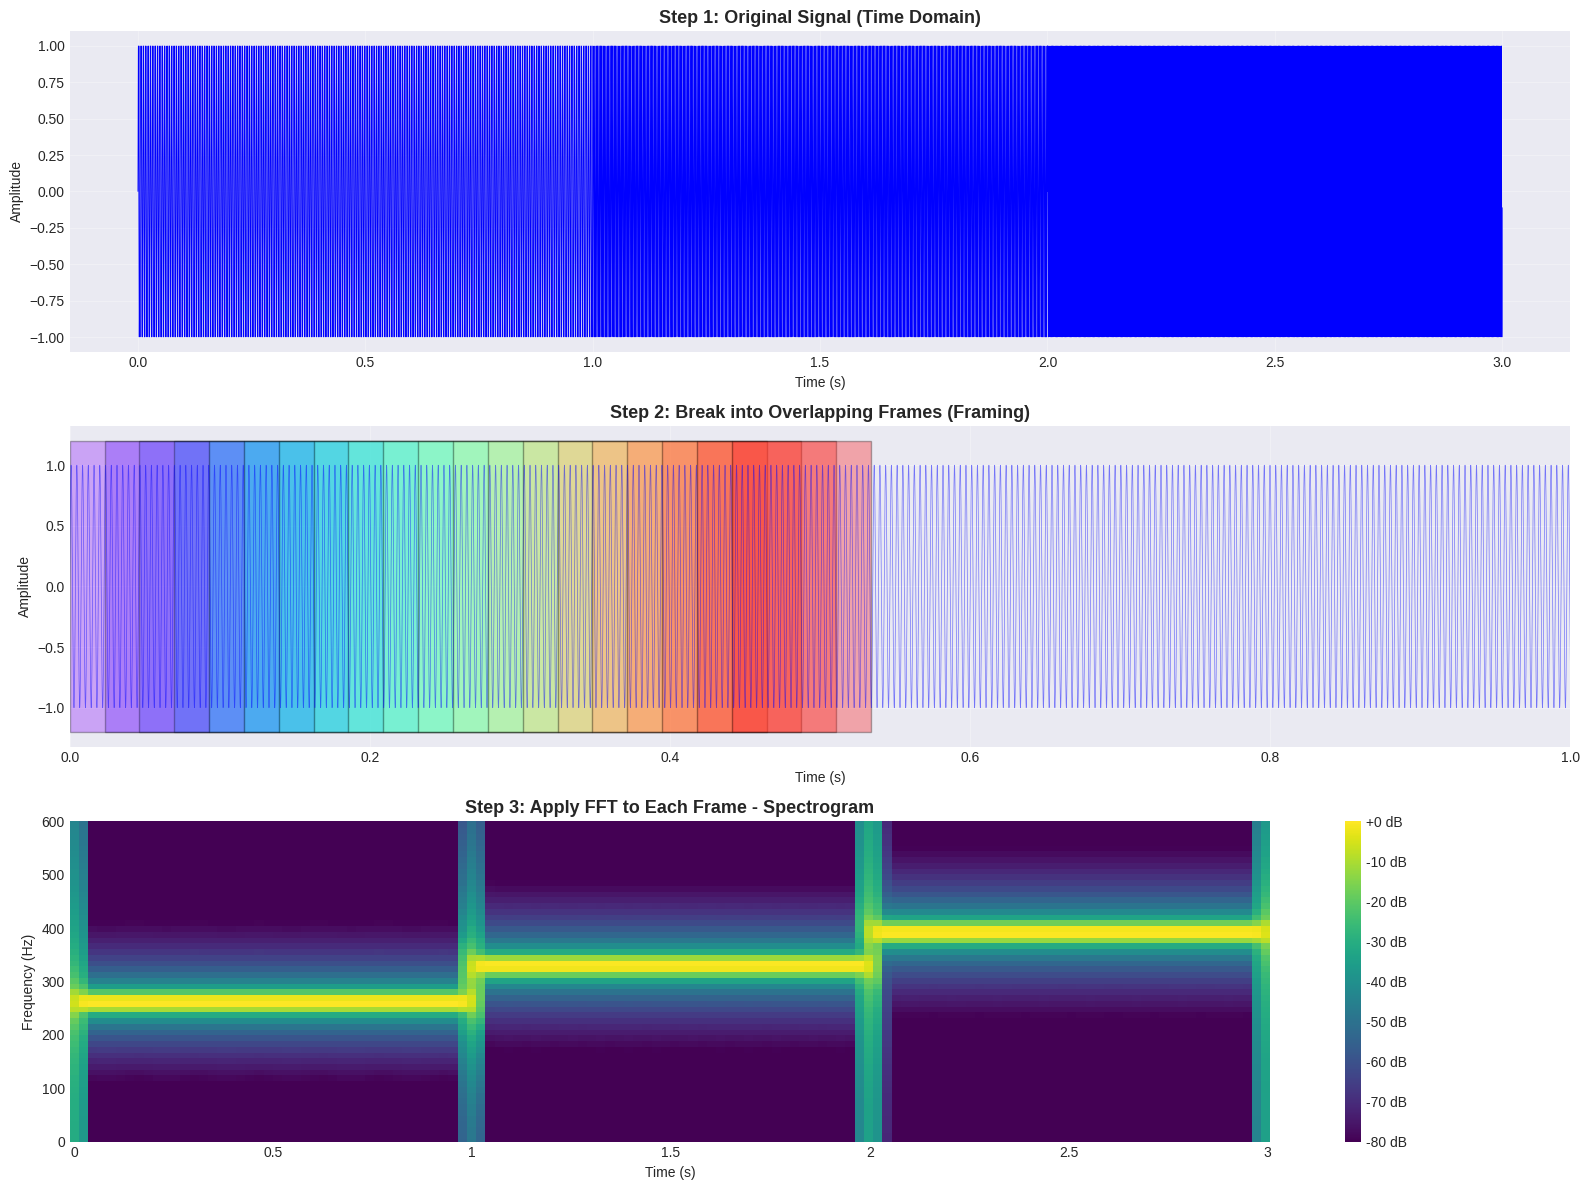

STFT Success!
Now we can see WHEN each frequency occurs
C4 (261 Hz) at 0-1s, E4 (329 Hz) at 1-2s, G4 (392 Hz) at 2-3s
Time and frequency information are both preserved!


In [3]:
from matplotlib.patches import Rectangle

fig, axes = plt.subplots(3, 1, figsize=(16, 12))

axes[0].plot(t_full, signal_sequential, linewidth=0.5, color='blue')
axes[0].set_title('Step 1: Original Signal (Time Domain)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].grid(True, alpha=0.3)

frame_size = 2048
hop_length = 512
num_frames = int((len(signal_sequential) - frame_size) / hop_length) + 1

axes[1].plot(t_full, signal_sequential, linewidth=0.5, color='blue', alpha=0.5)
colors = plt.cm.rainbow(np.linspace(0, 1, min(num_frames, 20)))

for i in range(min(num_frames, 20)):
    start_sample = i * hop_length
    end_sample = start_sample + frame_size
    start_time = start_sample / sr
    end_time = end_sample / sr
    
    rect = Rectangle((start_time, -1.2), end_time - start_time, 2.4,
                     alpha=0.3, facecolor=colors[i], edgecolor='black', linewidth=1)
    axes[1].add_patch(rect)

axes[1].set_title('Step 2: Break into Overlapping Frames (Framing)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Amplitude')
axes[1].set_xlim(0, 1)
axes[1].grid(True, alpha=0.3)

D = librosa.stft(signal_sequential, n_fft=frame_size, hop_length=hop_length, window='hann')
magnitude_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

img = librosa.display.specshow(magnitude_db, sr=sr, hop_length=hop_length,
                               x_axis='time', y_axis='hz', cmap='viridis', ax=axes[2])
axes[2].set_title('Step 3: Apply FFT to Each Frame - Spectrogram', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Frequency (Hz)')
axes[2].set_ylim(0, 600)
plt.colorbar(img, ax=axes[2], format='%+2.0f dB')

plt.tight_layout()
plt.show()

print("STFT Success!")
print("Now we can see WHEN each frequency occurs")
print("C4 (261 Hz) at 0-1s, E4 (329 Hz) at 1-2s, G4 (392 Hz) at 2-3s")
print("Time and frequency information are both preserved!")

---

## 3. 🔄 The STFT Process Step-by-Step

### Step 1: Framing & Windowing

**Framing**: Cut the signal into small blocks called **frames**

**Windowing**: Apply a **window function** to each frame to avoid artifacts

#### Why Windowing?

When we extract a frame, we create **discontinuities** at the edges (sudden jumps). These discontinuities cause **spectral leakage** - fake frequencies that weren't in the original signal.

**Solution**: Multiply each frame by a smooth window function (e.g., Hann window) that:
- Equals 1 in the middle of the frame
- Smoothly tapers to 0 at the edges
- Eliminates discontinuities

#### Key Parameters

**Frame Size (K or n_fft)**:
- Number of samples in each frame
- Determines frequency resolution
- Common values: 512, 1024, 2048, 4096

**Hop Length (H)**:
- Number of samples to shift between frames
- Determines time resolution and overlap
- Common: H = K/2 (50% overlap) or K/4 (75% overlap)

### Step 2: Apply DFT to Each Frame

For each windowed frame:
1. Compute the Discrete Fourier Transform (DFT)
2. Get a frequency vector (spectrum) for that moment in time
3. This shows the magnitude of each frequency in that frame

### Step 3: Stack the Results

1. Slide the window across the entire signal
2. Collect all frequency vectors
3. Stack them horizontally to create a **matrix**

**Result**: A 2D matrix where:
- **Rows** = Frequency bins
- **Columns** = Time frames
- **Values** = Magnitude at that frequency and time

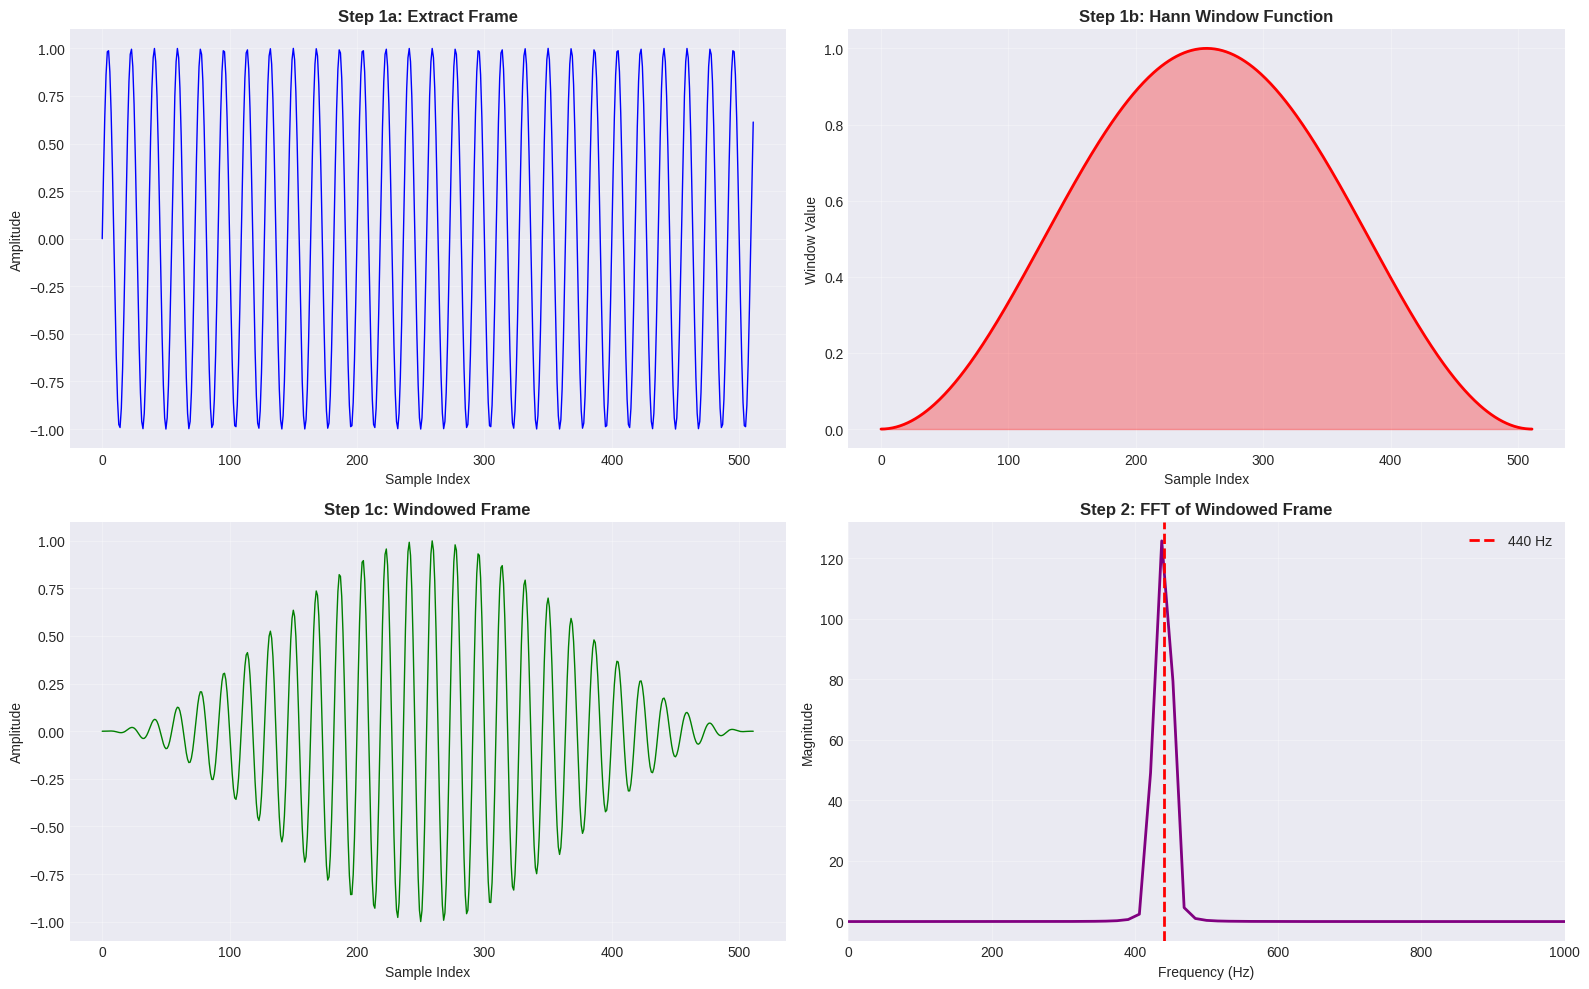

STFT Process Summary:
1. Extract frame: 512 samples
2. Apply Hann window: Smooth edges to prevent leakage
3. Compute FFT: Get frequency spectrum for this frame
4. Repeat: Slide by 256 samples and process next frame
5. Stack: Combine all frames into a 2D spectrogram matrix


In [4]:
sr_demo = 8000
duration_demo = 1.0
t_demo = np.linspace(0, duration_demo, int(sr_demo * duration_demo), endpoint=False)
test_signal = np.sin(2 * np.pi * 440 * t_demo)

frame_size = 512
hop_length = 256

frame_start = 1000
frame_end = frame_start + frame_size
single_frame = test_signal[frame_start:frame_end]

window = np.hanning(frame_size)
windowed_frame = single_frame * window

fft_frame = fft(windowed_frame)
magnitude_frame = np.abs(fft_frame[:frame_size//2])
freqs_frame = fftfreq(frame_size, 1/sr_demo)[:frame_size//2]

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

axes[0, 0].plot(single_frame, linewidth=1, color='blue')
axes[0, 0].set_title('Step 1a: Extract Frame', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Sample Index')
axes[0, 0].set_ylabel('Amplitude')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(window, linewidth=2, color='red')
axes[0, 1].fill_between(range(len(window)), 0, window, alpha=0.3, color='red')
axes[0, 1].set_title('Step 1b: Hann Window Function', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Sample Index')
axes[0, 1].set_ylabel('Window Value')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(windowed_frame, linewidth=1, color='green')
axes[1, 0].set_title('Step 1c: Windowed Frame', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Sample Index')
axes[1, 0].set_ylabel('Amplitude')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(freqs_frame, magnitude_frame, linewidth=2, color='purple')
axes[1, 1].axvline(x=440, color='red', linestyle='--', linewidth=2, label='440 Hz')
axes[1, 1].set_title('Step 2: FFT of Windowed Frame', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Frequency (Hz)')
axes[1, 1].set_ylabel('Magnitude')
axes[1, 1].set_xlim(0, 1000)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("STFT Process Summary:")
print(f"1. Extract frame: {frame_size} samples")
print(f"2. Apply Hann window: Smooth edges to prevent leakage")
print(f"3. Compute FFT: Get frequency spectrum for this frame")
print(f"4. Repeat: Slide by {hop_length} samples and process next frame")
print(f"5. Stack: Combine all frames into a 2D spectrogram matrix")

### Common Window Functions

| Window | Characteristics | Use Case |
|--------|-----------------|----------|
| **Hann** | Smooth, good balance | **Most common for audio** |
| **Hamming** | Better side lobe suppression | Speech processing |
| **Blackman** | Excellent leakage suppression | High precision needed |
| **Rectangular** | No tapering | ❌ Causes spectral leakage |

**Recommendation**: Use **Hann window** for most audio applications.

---

## 4. 📊 The Output: Spectrogram

### What is a Spectrogram?

A **spectrogram** is the visual representation of the STFT. It's a 2D image showing:

- **X-axis**: Time (time frames)
- **Y-axis**: Frequency (Hz)
- **Color/Intensity**: Magnitude (amplitude) of the frequency at that time

### Conversion to Decibels

$$
\text{Magnitude}_{dB} = 20 \log_{10}(\text{Magnitude})
$$

**Why dB scale?**
- Human hearing is logarithmic
- Better visualization of quiet and loud sounds
- Standard in audio processing

### Visual Interpretation

A spectrogram allows you to **"see" sound**:
- **Horizontal lines**: Sustained tones (notes)
- **Vertical lines**: Transients (percussive sounds)
- **Bright colors**: High energy (loud)
- **Dark colors**: Low energy (quiet)

---

## 5. ⚖️ The Time-Frequency Trade-off

### The Heisenberg Uncertainty Principle in Signal Processing

A fundamental limitation of STFT:

> **You cannot have perfect resolution in both time and frequency simultaneously.**

### The Trade-off

#### Large Frame Size (e.g., 4096 samples)

**Advantages:**
- ✅ **Good frequency resolution**: Detailed frequency bands
- ✅ Can distinguish close frequencies
- ✅ Better for pitch detection

**Disadvantages:**
- ❌ **Poor time resolution**: Don't know exactly when sounds start/stop
- ❌ Smearing in time
- ❌ Miss rapid transients

#### Small Frame Size (e.g., 512 samples)

**Advantages:**
- ✅ **Good time resolution**: Know exactly when events happen
- ✅ Capture rapid changes
- ✅ Better for rhythm detection

**Disadvantages:**
- ❌ **Poor frequency resolution**: Blurry frequency bands
- ❌ Can't distinguish close frequencies
- ❌ Less precise pitch information

### Mathematical Relationship

**Frequency Resolution**:
$$
\Delta f = \frac{s_r}{K}
$$

**Time Resolution**:
$$
\Delta t = \frac{K}{s_r}
$$

Where:
- $s_r$ = sample rate (Hz)
- $K$ = frame size (samples)

### Choosing Frame Size

| Application | Priority | Recommended Frame Size |
|-------------|----------|------------------------|
| **Pitch detection** | Frequency resolution | Large (2048-4096) |
| **Rhythm analysis** | Time resolution | Small (512-1024) |
| **General audio** | Balance | Medium (1024-2048) |
| **Speech recognition** | Balance | Medium (512-1024) |

---

## 6. 🎛️ Key Parameters Summary

### Essential STFT Parameters

#### 1. Frame Size (K or n_fft)

**Definition**: Number of samples in each frame

**Formula for duration**:
$$
d_f = \frac{K}{s_r}
$$

**Common values**:

| Sample Rate | Frame Size | Duration | Use Case |
|-------------|------------|----------|----------|
| 22,050 Hz | 512 | ~23 ms | Fast processing |
| 22,050 Hz | 1024 | ~46 ms | **Standard** |
| 22,050 Hz | 2048 | ~93 ms | High detail |
| 44,100 Hz | 2048 | ~46 ms | CD quality |

**Recommendation**: Start with **2048** at 22,050 Hz

#### 2. Hop Length (H)

**Definition**: Number of samples to shift between frames

**Overlap percentage**:
$$
\text{Overlap} = \left(1 - \frac{H}{K}\right) \times 100\%
$$

**Common values**:

| Hop Length | Overlap | Use Case |
|------------|---------|----------|
| K | 0% | ❌ Not recommended (data loss) |
| K/2 | 50% | **Standard** (good balance) |
| K/4 | 75% | High quality (more computation) |

**Recommendation**: Use **50% overlap** (H = K/2)

#### 3. Window Function

**Common choices**:
- **'hann'**: Most common, good balance ✅
- **'hamming'**: Better side lobe suppression
- **'blackman'**: Excellent leakage suppression

**Recommendation**: Use **'hann'** for most applications

---

## 7. 🐍 Implementation with Librosa

### Using librosa.stft()

```python
D = librosa.stft(y, n_fft=2048, hop_length=512, window='hann')
```

**Parameters**:
- `y`: Audio time series (1D numpy array)
- `n_fft`: Frame size (default: 2048)
- `hop_length`: Hop length (default: n_fft // 4)
- `window`: Window function (default: 'hann')

**Returns**:
- `D`: Complex-valued STFT matrix (shape: [n_freq_bins, n_time_frames])

### Processing the Output

```python
magnitude = np.abs(D)
magnitude_db = librosa.amplitude_to_db(magnitude, ref=np.max)
phase = np.angle(D)
```

In [5]:
sr = 22050
duration = 5.0
t = np.linspace(0, duration, int(sr * duration))

y = np.zeros(len(t))

melody_notes = [
    (261.63, 0.0, 0.5),
    (293.66, 0.5, 1.0),
    (329.63, 1.0, 1.5),
    (349.23, 1.5, 2.0),
    (392.00, 2.0, 2.5),
    (440.00, 2.5, 3.0),
    (493.88, 3.0, 3.5),
    (523.25, 3.5, 5.0),
]

for freq, start, end in melody_notes:
    start_idx = int(start * sr)
    end_idx = int(end * sr)
    t_note = t[start_idx:end_idx] - start
    
    note = (
        np.sin(2 * np.pi * freq * t_note) +
        0.5 * np.sin(2 * np.pi * 2 * freq * t_note) +
        0.25 * np.sin(2 * np.pi * 3 * freq * t_note)
    )
    
    envelope = np.exp(-3 * t_note)
    y[start_idx:end_idx] += note * envelope

y = y / np.max(np.abs(y))

print("Audio signal created")
print(f"Duration: {duration} seconds")
print(f"Sample rate: {sr} Hz")
print(f"Total samples: {len(y):,}")

ipd.Audio(y, rate=sr)

Audio signal created
Duration: 5.0 seconds
Sample rate: 22050 Hz
Total samples: 110,250


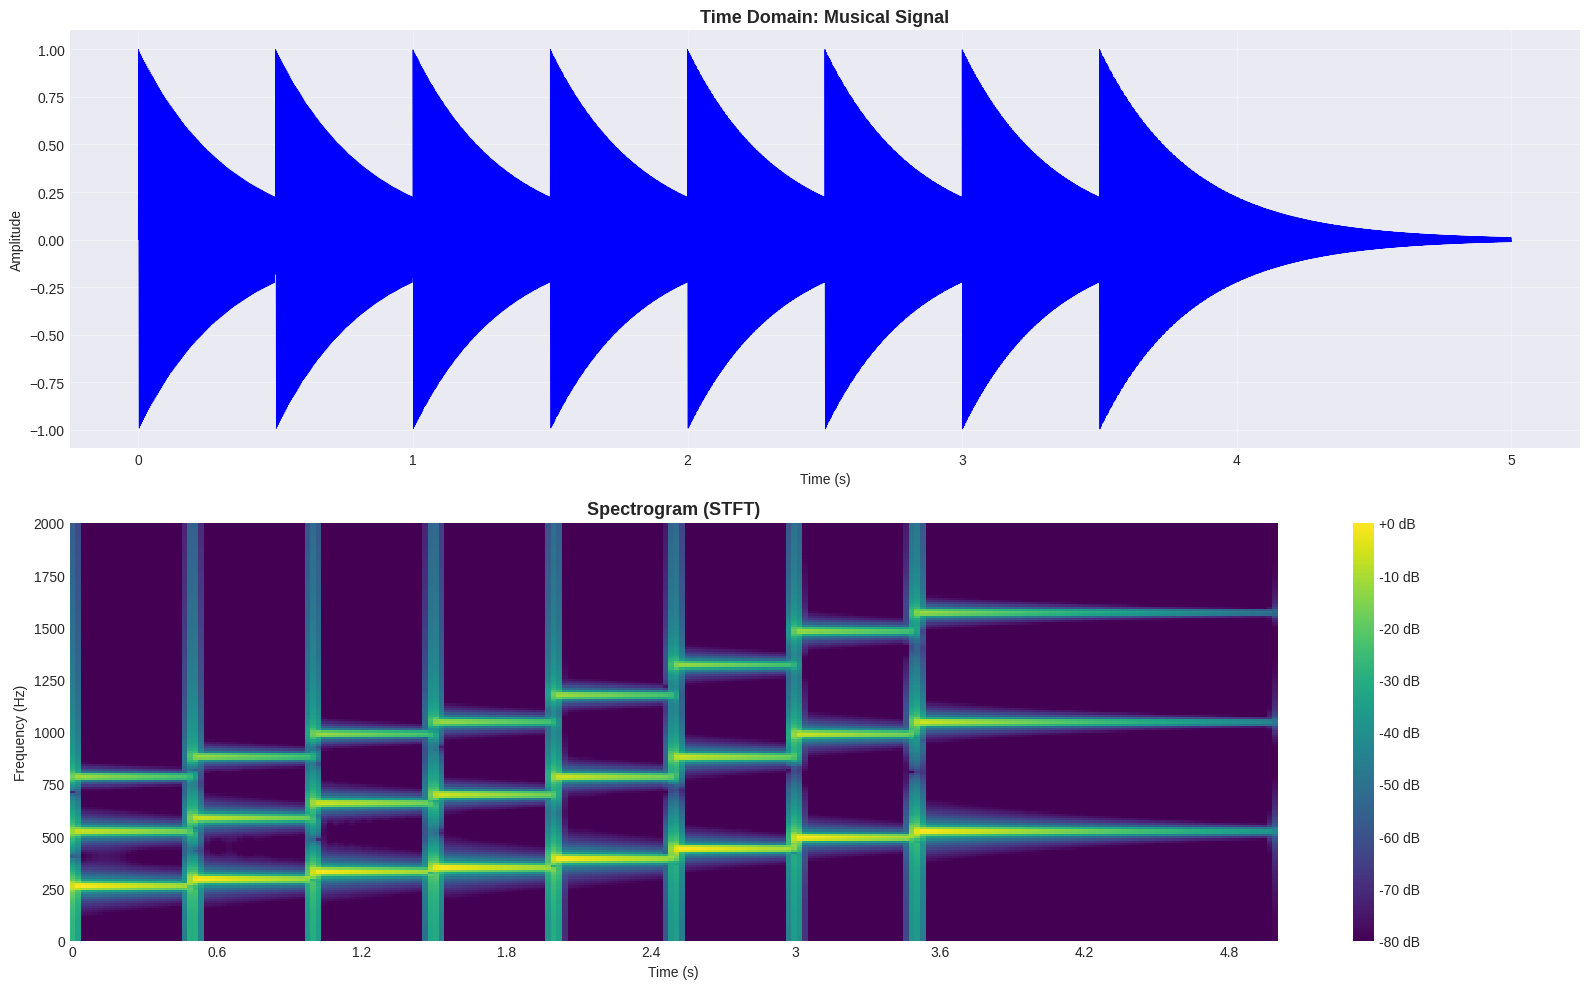

Spectrogram shape: (1025, 216)
Frequency bins: 1025
Time frames: 216
Frequency resolution: 10.77 Hz per bin
Time resolution: 23.22 ms per frame


In [6]:
n_fft = 2048
hop_length = 512

D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window='hann')
magnitude = np.abs(D)
magnitude_db = librosa.amplitude_to_db(magnitude, ref=np.max)

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

axes[0].plot(t, y, linewidth=0.5, color='blue')
axes[0].set_title('Time Domain: Musical Signal', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].grid(True, alpha=0.3)

img = librosa.display.specshow(magnitude_db, sr=sr, hop_length=hop_length,
                               x_axis='time', y_axis='hz', cmap='viridis', ax=axes[1])
axes[1].set_title('Spectrogram (STFT)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Frequency (Hz)')
axes[1].set_ylim(0, 2000)
plt.colorbar(img, ax=axes[1], format='%+2.0f dB')

plt.tight_layout()
plt.show()

print(f"Spectrogram shape: {magnitude.shape}")
print(f"Frequency bins: {magnitude.shape[0]}")
print(f"Time frames: {magnitude.shape[1]}")
print(f"Frequency resolution: {sr / n_fft:.2f} Hz per bin")
print(f"Time resolution: {hop_length / sr * 1000:.2f} ms per frame")

---

## 8. 🤖 Applications in AI/Deep Learning

### Why Spectrograms for Machine Learning?

Raw audio waveforms are difficult for neural networks to process:
- **High-dimensional**: 22,050 samples per second
- **Lack structure**: No clear spatial patterns
- **Temporal dependencies**: Long-range dependencies are hard to capture

### Spectrograms as Input Features

Spectrograms provide a **structured, image-like representation**:
- **2D structure**: Can use CNNs (Convolutional Neural Networks)
- **Frequency patterns**: Easier to learn than raw waveforms
- **Time-frequency localization**: Captures both temporal and spectral information

### Common Applications

1. **Audio Classification**
   - Music genre classification
   - Environmental sound recognition
   - Instrument recognition

2. **Speech Recognition**
   - Automatic Speech Recognition (ASR)
   - Speaker identification
   - Emotion recognition from speech

3. **Music Information Retrieval**
   - Beat tracking
   - Melody extraction
   - Music transcription

4. **Audio Generation**
   - Text-to-speech synthesis
   - Music generation
   - Voice conversion

### Typical ML Pipeline

```
Audio File → STFT → Spectrogram → CNN/RNN → Predictions
```

### Advanced Representations

Building on STFT:
- **Mel-Spectrogram**: Perceptually-weighted frequency scale
- **MFCCs**: Mel-Frequency Cepstral Coefficients
- **Log-Mel Spectrogram**: Logarithmic scaling for better dynamic range

---

## 9. 📝 Summary and Best Practices

### Key Concepts Recap

1. **The Problem**: Standard FFT loses time information
2. **The Solution**: STFT analyzes short frames sequentially
3. **The Process**: Framing → Windowing → FFT → Stacking
4. **The Output**: Spectrogram (time-frequency representation)
5. **The Trade-off**: Cannot have perfect time AND frequency resolution

### Best Practices

| Parameter | Recommended Value | Notes |
|-----------|------------------|-------|
| **Sample Rate** | 22,050 Hz | Standard for ML applications |
| **Frame Size (n_fft)** | 2048 | Good balance, ~93 ms at 22,050 Hz |
| **Hop Length** | 512 (n_fft/4) | 75% overlap, good quality |
| **Window** | 'hann' | Best general-purpose choice |

### When to Adjust Parameters

**Use larger frame size (4096) when:**
- Precise pitch detection is critical
- Analyzing harmonic content
- Working with low-frequency signals

**Use smaller frame size (512) when:**
- Precise timing is critical
- Detecting transients or onsets
- Analyzing percussive sounds

### Common Pitfalls to Avoid

❌ **Don't use rectangular window** - causes spectral leakage  
❌ **Don't use 0% overlap** - loses information at frame boundaries  
❌ **Don't forget to convert to dB** - linear scale is hard to visualize  
❌ **Don't ignore the trade-off** - choose parameters based on your application  

### Next Steps

1. **Explore Mel-Spectrograms**: Perceptually-weighted frequency representation
2. **Learn MFCCs**: Compact representation for speech/audio
3. **Apply to real audio**: Load and analyze your own audio files
4. **Build ML models**: Use spectrograms as input to neural networks

### Resources

- **GitHub**: [AudioSignalProcessingForML](https://github.com/musikalkemist/AudioSignalProcessingForML)
- **PDF Reference**: [STFT Explained Easily](https://github.com/musikalkemist/AudioSignalProcessingForML/blob/master/15%20-%20Short-Time%20Fourier%20Transform%20explained%20easily/Short-Time%20Fourier%20Transform%20Explained%20Easily.pdf)
- **Community**: The Sound of AI Slack community

---

## 🎉 Congratulations!

You now understand:
- ✅ Why STFT is needed for non-stationary signals
- ✅ How STFT works (framing, windowing, FFT, stacking)
- ✅ The time-frequency trade-off
- ✅ How to choose appropriate parameters
- ✅ How to implement STFT with librosa
- ✅ Applications in AI and deep learning

**You're ready to apply STFT to real audio processing tasks!** 🚀